In [2]:
# Retrieve the data as a geopandas dataframe

import geopandas as geopd
from owslib.wfs import WebFeatureService
from requests import Request

wfs_server = 'https://data.ipsl.fr/geoserver/tephra/ows'
wfs = WebFeatureService(url=wfs_server, version='1.1.0')
layer = list(wfs.contents)[0]

# Specify the parameters for fetching the data
params = dict(service='WFS', version="1.0.0", request='GetFeature',
      typeName=layer, outputFormat='json')

# Parse the URL with parameters
q = Request('GET', wfs_server, params=params).prepare().url

# Read data from URL
BOOM_geodf = geopd.read_file(q, encoding="latin1")

import sys
sys.path.insert(1, '../Scripts')
from functions import sort_BOOM
# when retrieving the data from the server, attributes might not be grouped by type, 
#     we use the sort_BOOM function to group them

BOOM_geodf = sort_BOOM(BOOM_geodf)

In the dataset, the data was stored as in the original publication. Because of this, in many cases the assigned value to a particular element might not be a number but an expresion to indicate: missingness, lower than a certain value, below detection limit (bdl) or over range. In order to treat the data, these values are replaced by NAN. In order to process the data it is necesary to replace these expressions by "NaN".

In [3]:
import numpy as np

BOOM_geodf =BOOM_geodf.replace(to_replace=dict.fromkeys(['Over range','bld',
                                                         '<0.01','<0.1','<1','<5','<6','<10',
                                                         'n.a.','Not analyzed','Not Netermined','-']),value=np.nan)

For evaluating the effect that analyzing different major elements has on their normalization, we are only interested in Sample Observations where major elements have been analyzed:

In [4]:
BOOM_geodf = BOOM_geodf.dropna(subset=['properties.SiO2'],axis=0,how='any')

Because of their relatively lower concentrations, the analysis of MnO, P2O5 and Cl is longer and thus in some studies, they might not be analyzed. In the following we asses the *missingness* of these major elements. 

Case 1: Samples where Cl, P2O5 y MnO were analyzed:  2493
Case 2: Samples where Cl and P2O5 were analyzed, but not MnO:  0
Case 3: Samples where Cl and MnO were analyzed, but not P2O5:  855
Case 4: Samples where Cl was analyzed, but neither P2O5, nor MnO were:  0
Case 5: Samples where Cl was not analyzed, but P2O5 and MnO were:  5975
Case 6: Samples where Cl and MnO were not analyzed, but P2O5 was:  1
Case 7: Samples where Cl nor P2O5 were analyzed, but MnO was:  10
Case 8: Samples where neither Cl not MnO were analyzed, but P2O5 was:  529


<AxesSubplot:>

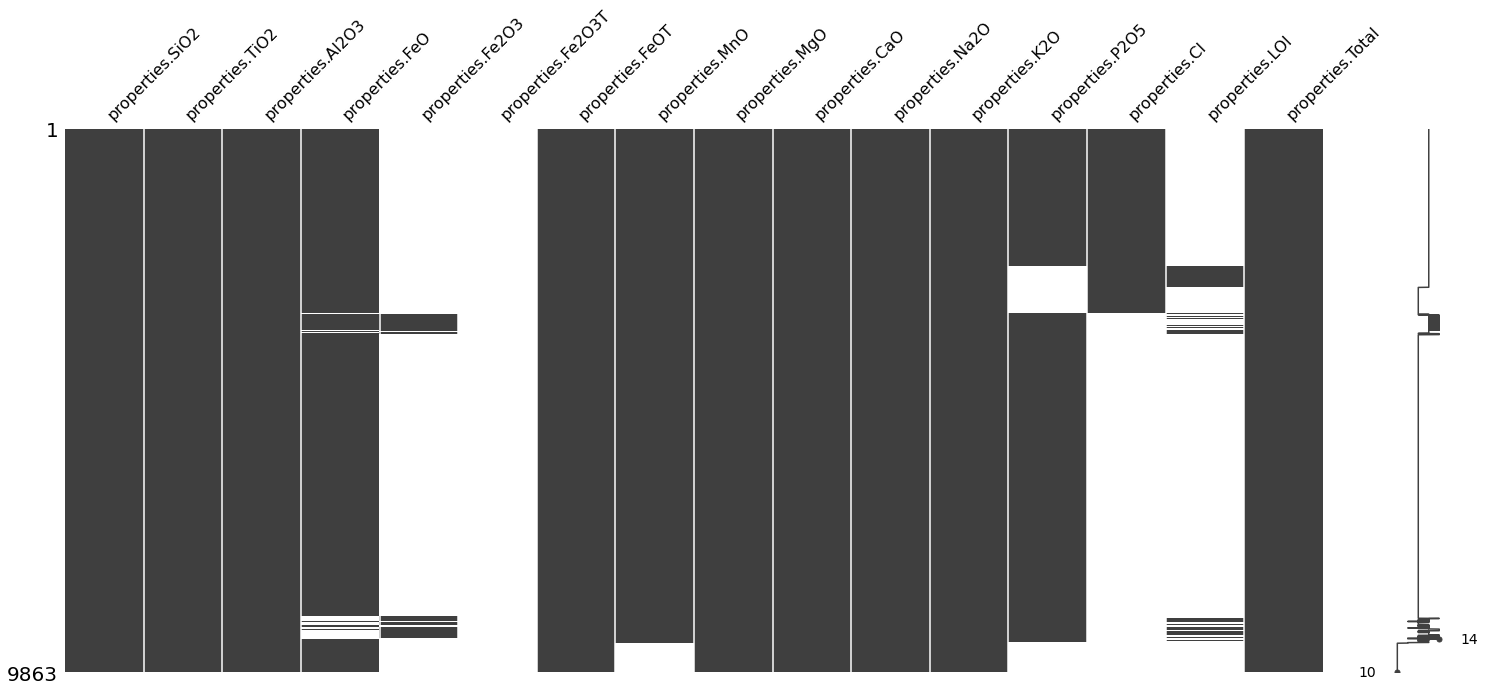

In [5]:
BOOM_geodf = BOOM_geodf.replace(np.nan,-1)
temp1 = BOOM_geodf[BOOM_geodf['properties.Total'] != -1]

temp1_1 = temp1[temp1['properties.Cl'] != -1]
temp1_1_1 = temp1_1[temp1_1['properties.P2O5'] != -1]
case1 = temp1_1_1[temp1_1_1['properties.MnO'] != -1]; case2 = temp1_1_1[temp1_1_1['properties.MnO'] == -1]
print('\033[1mCase 1: Samples where Cl, P2O5 y MnO were analyzed: \033[0m {}'.format(len(case1)))
temp1_1_1_1_ms =  case1.replace(np.nan,-1)
print('\033[1mCase 2: Samples where Cl and P2O5 were analyzed, but not MnO: \033[0m {}'.format(len(case2)))
case1 = case1.replace(-1,np.nan);case2 = case2.replace(-1,np.nan)

temp1_1_2 = temp1_1[temp1_1['properties.P2O5'] == -1]
temp1_1_2_1 = temp1_1_2[temp1_1_2['properties.MnO'] != -1];temp1_1_2_2 = temp1_1_2[temp1_1_2['properties.MnO'] == -1]
case3 = temp1_1_2_1.replace(-1,np.nan); case4 = temp1_1_2_2.replace(-1,np.nan)
print('\033[1mCase 3: Samples where Cl and MnO were analyzed, but not P2O5: \033[0m {}'.format(len(case3)))
print('\033[1mCase 4: Samples where Cl was analyzed, but neither P2O5, nor MnO were: \033[0m {}'.format(len(case4)))

temp1_2 = temp1[temp1['properties.Cl'] == -1]
temp1_2_1 = temp1_2[temp1_2['properties.P2O5'] != -1]
temp1_2_1_1 = temp1_2_1[temp1_2_1['properties.MnO'] != -1];temp1_2_1_2 = temp1_2_1[temp1_2_1['properties.MnO'] == -1]
case5 = temp1_2_1_1.replace(-1,np.nan); case6 = temp1_2_1_2.replace(-1,np.nan)
print('\033[1mCase 5: Samples where Cl was not analyzed, but P2O5 and MnO were: \033[0m {}'.format(len(case5)))
print('\033[1mCase 6: Samples where Cl and MnO were not analyzed, but P2O5 was: \033[0m {}'.format(len(case6)))

temp1_2_2 = temp1_2[temp1_2['properties.P2O5'] == -1]
temp1_2_2_1 = temp1_2_2[temp1_2_2['properties.MnO'] != -1];temp1_2_2_2 = temp1_2_2[temp1_2_2['properties.MnO'] == -1]
case7 = temp1_2_2_1.replace(-1,np.nan); case8 = temp1_2_2_2.replace(-1,np.nan)
print('\033[1mCase 7: Samples where Cl nor P2O5 were analyzed, but MnO was: \033[0m {}'.format(len(case7)))
print('\033[1mCase 8: Samples where neither Cl not MnO were analyzed, but P2O5 was: \033[0m {}'.format(len(case8)))
#fig_copy.savefig('../Plots/MissingnessMajorElements.png')
BOOM_geodf = BOOM_geodf.replace(-1,np.nan)

import missingno as msno
import pandas as pd

msno.matrix(pd.concat([case1,case2,case3,case4,case5,case6,case7,case8]).loc[:,'properties.SiO2':'properties.Total'])

In order to test the effect of analyzing different major elements has on their normalization, we re-normalize sample observations from case1 (all major elements have been analyzed), by a new total:

    new_Total = SiO2 + TiO2 + Al2O3 + MgO + CaO + Na2O + K2O (i.e. without MnO, P2O5 or CL) (1)

and calculate the difference between the normalized values as:

    Δ_major_element = major_element_original - major_element_new_Total (2)

Then, we compare the Δ_major_element with the precision (1 SD) with which the different major elements can be analyzed for each geostandard analyzed along with the samples (as indicated by certified values of the geostandards). From the comparison (3), the difference in the normalization is smaller than the precision of the different elements, and thus we conclude that sample observations normalized by *different* totals (computed as the sum of *different* major elements), can be compared.  

In [6]:
# (1)
from functions import renormalizing

case1_renormalized = renormalizing(case1)

In [7]:
case1_renormalized.loc[:,'properties.SiO2_normalized':'properties.K2O_normalized'].describe()

properties.SiO2_normalized  properties.TiO2_normalized  \
count                 2493.000000                 2493.000000   
mean                    64.379159                    1.021616   
std                      4.974441                    0.394372   
min                     53.268081                    0.147285   
25%                     60.782344                    0.655285   
50%                     64.426979                    1.040994   
75%                     69.098258                    1.321690   
max                     77.737408                    2.126141   

       properties.Al2O3_normalized  properties.FeOT_normalized  \
count                  2493.000000                 2493.000000   
mean                     15.807847                    5.733976   
std                       0.813164                    2.464706   
min                      11.815468                    1.048054   
25%                      15.399389                    3.277361   
50%                      15.838088                    5.678623   
75%                      16.279010                    7.574665   
max                      24.418471                   11.841387   

       properties.MgO_normalized  properties.CaO_normalized  \
count                2493.000000                2493.000000   
mean                    1.812562                   4.275825   
std                     1.210450                   1.910315   
min                     0.119473                   1.186622   
25%                     0.725751                   2.424579   
50%                     1.520189                   4.096645   
75%                     2.433940                   5.494798   
max                     7.134234                   9.635051   

       properties.Na2O_normalized  properties.K2O_normalized  
count                 2493.000000                2493.000000  
mean                     5.178727                   1.790289  
std                      0.772527                   0.536713  
min                      2.895501                   0.424091  
25%                      4.754380                   1.377892  
50%                      5.269760                   1.752629  
75%                      5.770236                   2.243728  
max                      6.664763                   3.841012

In [15]:
# (2)

#load MeasurementRuns file to now the secondary standards measured along with the samples
import requests
from io import StringIO

standard_url = "https://data.ipsl.fr/repository/TephraDatabase/TephraDataBase_Standards.csv"
s=requests.get(standard_url).text
BOOM_geostandards = pd.read_csv(StringIO(s), encoding="latin1")
BOOM_geostandards.loc[:,'MeasurementRun'] = BOOM_geostandards.loc[:,'MeasurementRun'].astype('str')
case1_renormalized.loc[:,'properties.MeasurementRun'] = case1_renormalized.loc[:,'properties.MeasurementRun'].astype('str')

#load the Secondary standards reference values
Standards_ref = pd.read_excel('../Data/Standards_Reference.xlsx')
Standards_ref = Standards_ref[Standards_ref.error.isin(['95%CL','SD'])].copy()

#get which secondary standards where analyzed along with the samples
stds = BOOM_geostandards[BOOM_geostandards.MeasurementRun.isin(case1_renormalized['properties.MeasurementRun'].unique())].StandardID.unique()
Standards_ref_case1 = Standards_ref[Standards_ref.StandardID.isin(stds)]

case1 = case1.reset_index()
case1_renormalized['ΔSiO2'] = np.subtract(case1_renormalized['properties.SiO2_normalized'],case1['properties.SiO2_normalized'])
case1_renormalized['ΔTiO2'] = np.subtract(case1_renormalized['properties.TiO2_normalized'],case1['properties.TiO2_normalized'])
case1_renormalized['ΔAl2O3'] = np.subtract(case1_renormalized['properties.Al2O3_normalized'],case1['properties.Al2O3_normalized'])
case1_renormalized['ΔFeOT'] = np.subtract(case1_renormalized['properties.FeOT_normalized'],case1['properties.FeOT_normalized'])
case1_renormalized['ΔMgO'] = np.subtract(case1_renormalized['properties.MgO_normalized'],case1['properties.MgO_normalized'])
case1_renormalized['ΔCaO'] = np.subtract(case1_renormalized['properties.CaO_normalized'],case1['properties.CaO_normalized'])
case1_renormalized['ΔNa2O'] = np.subtract(case1_renormalized['properties.Na2O_normalized'],case1['properties.Na2O_normalized'])
case1_renormalized['ΔK2O'] = np.subtract(case1_renormalized['properties.K2O_normalized'],case1['properties.K2O_normalized'])

KeyError: 'properties.SiO2_normalized'

In [14]:
# (3)

import plotly.express as px
import plotly.graph_objects as go

elementos = ['SiO2','TiO2','Al2O3','FeOT',
             'MgO','CaO','Na2O','K2O']

for elemento in elementos: #['SiO2','Al2O3']:
    plot1 = go.Scatter(x=case1_renormalized['properties.'+elemento+'_normalized'],
               y=case1_renormalized['Δ'+elemento],
               mode = 'markers',
               hovertext = 'Sample Observation ID: ' + case1_renormalized['properties.SampleObservationID'].astype('str') + ' '+ 
                       case1_renormalized['properties.Authors'].astype('str') ,
               marker = dict(color=case1_renormalized['MnO + P2O5 + Cl'],showscale = True),
               name = "MnO + P2O5 + Cl")

    plot2 = go.Scatter(x = Standards_ref_case1[elemento],
                  y = Standards_ref_case1['σ_'+elemento],
                  text = Standards_ref_case1.StandardID ,
                  hovertext = 'Secondary standard: ' + Standards_ref_case1.StandardID  , 
                  mode = 'markers+text',
                  textposition = 'top center' ,
                  showlegend = False ,
                  line = {'color': "#3b3b3b"})

    Data = [plot1,plot2]
    layout = go.Layout(xaxis=dict(title=elemento), yaxis=dict(title='Δ'+elemento),
                      legend={'y':1.1, 'x':0.98}, width=800, height=500)# title='Re-normalization variation',
    
    fig = go.Figure(data=Data,layout=layout)
    fig.show()

    #fig.write_image('../Plots/temp.png')